In [1]:
import pickle
import sys
import os
from itertools import product
import math
import numpy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from scipy.cluster.hierarchy import dendrogram, leaves_list
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE, MDS
# import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime

sys.path.append(os.path.abspath("../"))
from distance_functions import *

In [2]:
start_time = datetime.datetime.now()

# Load representations and distance estimates with increasing n

In [3]:
load_from_saved = True ## Set to False if you want to recompute all of the distance estimates with different n

lambda_vals = [np.inf,3,2,1,0,-1]
n_vals = np.arange(2800,10200,800)

In [4]:
reps_prefix = '../../imagenet_experiments/'
stats = np.load(f"{reps_prefix}distances/train/pretrained/stats.npz")
model_names = stats["model_names"]
old_model_names = model_names
sub_index = np.where(np.asarray(range(len(old_model_names))) % 3 == 0)
# print(sub_index)
model_names = np.asarray([old_model_names[i] for i in sub_index])[0,:]

# Because of time constraints, do it for a subset of the models
model_names = model_names[1:]
print(model_names)

['convnext_small_pretrained_rep' 'efficientnet_b1_pretrained_rep'
 'efficientnet_b4_pretrained_rep' 'efficientnet_b7_pretrained_rep'
 'mnasnet_pretrained_rep' 'mobilenet_v3_small_pretrained_rep'
 'regnet_x_32gf_pretrained_rep' 'regnet_x_800mf_pretrained_rep'
 'regnet_y_1_6gf_pretrained_rep' 'regnet_y_400mf_pretrained_rep'
 'resnet18_pretrained_rep' 'wide_resnet50_2_pretrained_rep']


In [5]:
reps_prefix = '../../imagenet_experiments/'
# reps_prefix = ''

if not load_from_saved:
#     folder = "estimated_distances_increasing_n/pretrained"
    folder = None
    
    # Load ImageNet representations
    n1 = 10000
    n2 = 10000
    reps1 = {}
    reps2 = {}
    for model_name in model_names:
        print(model_name)
        rep = np.load(reps_prefix + "reps/train/20000_eval/" + model_name + ".npy")
        print(rep.shape)
        rep1 = rep[:,0:n1]
        rep2 = rep[:,n1:n1+n2]
        # center and normalize
        rep1 = rep1 - rep1.mean(axis=1, keepdims=True)
        rep1 = rep1 / np.linalg.norm(rep1)
        rep1 = rep1 * np.sqrt(rep1.shape[1])
        reps1[model_name] = rep1

        rep2 = rep2 - rep2.mean(axis=1, keepdims=True)
        rep2 = rep2 / np.linalg.norm(rep2)
        rep2 = rep2 * np.sqrt(rep2.shape[1])
        reps2[model_name] = rep2

convnext_small_pretrained_rep
(768, 20000)
efficientnet_b1_pretrained_rep
(1280, 20000)
efficientnet_b4_pretrained_rep
(1792, 20000)
efficientnet_b7_pretrained_rep
(2560, 20000)
mnasnet_pretrained_rep
(1280, 20000)
mobilenet_v3_small_pretrained_rep
(1024, 20000)
regnet_x_32gf_pretrained_rep
(2520, 20000)
regnet_x_800mf_pretrained_rep
(672, 20000)
regnet_y_1_6gf_pretrained_rep
(888, 20000)
regnet_y_400mf_pretrained_rep
(440, 20000)
resnet18_pretrained_rep
(512, 20000)
wide_resnet50_2_pretrained_rep
(2048, 20000)


In [6]:
def load_dists(reps, lambda_vals, n_vals):
    d_mat = {}
    evals_evecs = {}
    for model_name in model_names:
        print(model_name)
        for n_ind in range(len(n_vals)):
            n = n_vals[n_ind]
            A = reps[model_name][:,0:n]
            evals_a, evecs_a = np.linalg.eigh(A @ A.T)
            evals_evecs[(model_name, n)] = (evals_a, evecs_a)

    for ind_1 in range(len(model_names)):
        print(ind_1,'/',len(model_names))
        model_name1 = model_names[ind_1]
        for ind_2 in range(ind_1+1,len(model_names)):
            model_name2 = model_names[ind_2]
            print(model_name1, model_name2)
            new_mat = np.zeros((len(lambda_vals),len(n_vals)))

            for n_ind in range(len(n_vals)):
                n = n_vals[n_ind]
                A = reps[model_name1][:,0:n]
                B = reps[model_name2][:,0:n]
                evals_a, evecs_a = evals_evecs[(model_name1, n)]
                evals_b, evecs_b = evals_evecs[(model_name2, n)]
    #             print(n)
                for i in range(len(lambda_vals)):
                    if lambda_vals[i] == np.inf:
                        curr_dist = predictor_dist(A, B, evals_a=evals_a, evecs_a = evecs_a, evals_b = evals_b, evecs_b = evecs_b, lmbda=0)
    #                     print('0\t',curr_dist)
                        new_mat[i,n_ind] = curr_dist
                    else:
                        curr_dist = predictor_dist(A, B, evals_a=evals_a, evecs_a = evecs_a, evals_b = evals_b, evecs_b = evecs_b, lmbda=math.pow(10,-lambda_vals[i]))
    #                     print('1e-' + str(lambda_vals[i]) + '\t',curr_dist)
                        new_mat[i,n_ind] = curr_dist

            d_mat[(model_name1, model_name2)] = new_mat
    return d_mat

In [7]:
if not load_from_saved:
    d_mat1 = load_dists(reps1, lambda_vals, n_vals)
    pickle.dump(d_mat1, open("./estimated_distances_increasing_n/trained/imagenet_dists_10000_v1.pkl", "wb"))
else:
    d_mat1 = pickle.load(open("./estimated_distances_increasing_n/trained/imagenet_dists_10000_v1.pkl", "rb"))

convnext_small_pretrained_rep
efficientnet_b1_pretrained_rep
efficientnet_b4_pretrained_rep
efficientnet_b7_pretrained_rep
mnasnet_pretrained_rep
mobilenet_v3_small_pretrained_rep
regnet_x_32gf_pretrained_rep
regnet_x_800mf_pretrained_rep
regnet_y_1_6gf_pretrained_rep
regnet_y_400mf_pretrained_rep
resnet18_pretrained_rep
wide_resnet50_2_pretrained_rep
0 / 12
convnext_small_pretrained_rep efficientnet_b1_pretrained_rep
convnext_small_pretrained_rep efficientnet_b4_pretrained_rep
convnext_small_pretrained_rep efficientnet_b7_pretrained_rep
convnext_small_pretrained_rep mnasnet_pretrained_rep
convnext_small_pretrained_rep mobilenet_v3_small_pretrained_rep
convnext_small_pretrained_rep regnet_x_32gf_pretrained_rep
convnext_small_pretrained_rep regnet_x_800mf_pretrained_rep
convnext_small_pretrained_rep regnet_y_1_6gf_pretrained_rep
convnext_small_pretrained_rep regnet_y_400mf_pretrained_rep
convnext_small_pretrained_rep resnet18_pretrained_rep
convnext_small_pretrained_rep wide_resnet50_2_

In [8]:
if not load_from_saved:
    d_mat2 = load_dists(reps2, lambda_vals, n_vals)
    pickle.dump(d_mat2, open("estimated_distances_increasing_n/trained/imagenet_dists_10000_v2.pkl", "wb"))
    
else:
    d_mat2 = pickle.load(open("estimated_distances_increasing_n/trained/imagenet_dists_10000_v2.pkl", "rb"))

convnext_small_pretrained_rep
efficientnet_b1_pretrained_rep
efficientnet_b4_pretrained_rep
efficientnet_b7_pretrained_rep
mnasnet_pretrained_rep
mobilenet_v3_small_pretrained_rep
regnet_x_32gf_pretrained_rep
regnet_x_800mf_pretrained_rep
regnet_y_1_6gf_pretrained_rep
regnet_y_400mf_pretrained_rep
resnet18_pretrained_rep
wide_resnet50_2_pretrained_rep
0 / 12
convnext_small_pretrained_rep efficientnet_b1_pretrained_rep
convnext_small_pretrained_rep efficientnet_b4_pretrained_rep
convnext_small_pretrained_rep efficientnet_b7_pretrained_rep
convnext_small_pretrained_rep mnasnet_pretrained_rep
convnext_small_pretrained_rep mobilenet_v3_small_pretrained_rep
convnext_small_pretrained_rep regnet_x_32gf_pretrained_rep
convnext_small_pretrained_rep regnet_x_800mf_pretrained_rep
convnext_small_pretrained_rep regnet_y_1_6gf_pretrained_rep
convnext_small_pretrained_rep regnet_y_400mf_pretrained_rep
convnext_small_pretrained_rep resnet18_pretrained_rep
convnext_small_pretrained_rep wide_resnet50_2_

# Plot relative error with respect to estimate with largest n

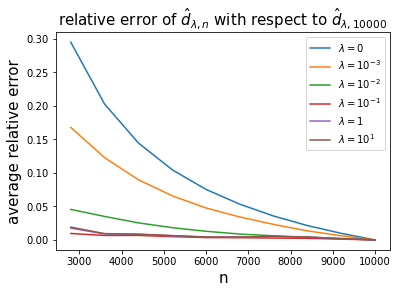

In [9]:
# Plot relative error of d_mat1 with respect to final value

for i in range(len(lambda_vals)):
    if lambda_vals[i] == np.inf:
        currlabel = '$\lambda = 0$'
    elif lambda_vals[i] == 0:
        currlabel = '$\lambda = 1$'
    elif lambda_vals[i] >= 0:
        currlabel ='$\lambda = 10^{-' + str(lambda_vals[i]) + '}$'
    elif lambda_vals[i] < 0:
        currlabel ='$\lambda = 10^{' + str(-lambda_vals[i]) + '}$'
    
    curr_l = np.zeros(len(n_vals))
    curr_err = np.zeros(len(n_vals))
    for ind_1 in range(len(model_names)):
        model_name1 = model_names[ind_1]
        for ind_2 in range(ind_1+1, len(model_names)):
            model_name2 = model_names[ind_2]
            
            curr_mat = d_mat1[(model_name1, model_name2)]
            final_val = curr_mat[i,-1]
            curr_l = curr_l + curr_mat[i,:] / final_val
            curr_err = curr_err + np.abs((curr_mat[i,:] - final_val) / final_val)
    avg_err = curr_err / (len(model_names) * (len(model_names) - 1) / 2)
    avg_l = curr_l / (len(model_names) * (len(model_names) - 1) / 2)
#     diff_l = avg_l[0:-2] - avg_l[1:-1]
#     print(diff_l)
#     plt.plot(n_vals, avg_l, label=currlabel)
    plt.plot(n_vals, avg_err, label=currlabel)
#     plt.ylim((0,2))
#     plt.ylim((-0.2,0.2))
plt.legend()
plt.title('relative error of $\hat{d}_{\lambda,n}$ with respect to $\hat{d}_{\lambda,10000}$', fontsize=15)
plt.xlabel('n', fontsize=15)
plt.ylabel('average relative error', fontsize=15)
plt.savefig('../paper_figures/convergence_relative_error.pdf')
plt.show()

# Compare estimates with independent samples

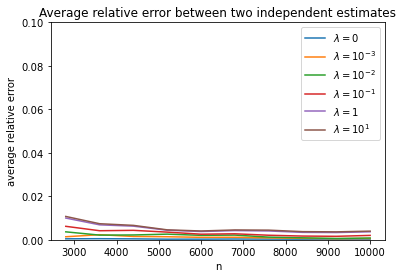

In [10]:
# Compute the average relative error for two independent runs

avg_errs = np.zeros((len(lambda_vals), len(n_vals)))
for i in range(0,len(lambda_vals)):
    if lambda_vals[i] == np.inf:
        currlabel = '$\\lambda = 0$'
    elif lambda_vals[i] == 0:
        currlabel = '$\\lambda = 1$'
    elif lambda_vals[i] >= 0:
        currlabel ='$\\lambda = 10^{-' + str(lambda_vals[i]) + '}$'
    elif lambda_vals[i] < 0:
        currlabel ='$\\lambda = 10^{' + str(-lambda_vals[i]) + '}$'
    
    broken = np.zeros(len(n_vals))
    avg_err = np.zeros(len(n_vals))
    for ind_1 in range(len(model_names)):
        model_name1 = model_names[ind_1]
        for ind_2 in range(ind_1+1, len(model_names)):
            model_name2 = model_names[ind_2]
            
            v0 = curr_mat1 = d_mat1[(model_name1, model_name2)][i,:]
            v1 = curr_mat2 = d_mat2[(model_name1, model_name2)][i,:]

            rel_err = np.abs(v0 - v1) / (v0 + v1)

            broken = broken + (v0 <= 0)
            broken = broken + (v1 <= 0)

            avg_err += rel_err
    avg_errs[i,:] = avg_err / ((len(model_names) * (len(model_names) - 1) / 2))
#     print(broken)
    if np.any(broken):
        print(f'WARNING: Omitting some values from log10(lambda)={lambda_vals[i]}, due to numerical precision issues')
    not_broken = np.ndarray.flatten(np.asarray(np.where(broken < 1)))

    plt.plot(n_vals[not_broken], avg_errs[i,not_broken], label=currlabel)
    plt.ylim((0,0.1))

plt.title('Average relative error between two independent estimates')
plt.xlabel('n')
plt.ylabel('average relative error')
plt.legend()
plt.savefig('../paper_figures/convergence_relative_error_indep_trials.pdf')
plt.show()

In [11]:
end_time = datetime.datetime.now()
print('Time elapsed:',end_time - start_time)

Time elapsed: 0:28:39.261894
